In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import time

## Read data

In [2]:
from src.features import *
train = load_raw()
cols = imply_columns(train)

In [3]:
assert not train['Unnamed: 0'].duplicated().any()

In [4]:
train = train.set_index('Unnamed: 0')

In [5]:
train.shape, train.columns

((195402, 39),
 Index(['1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
        '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]',
        '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]',
        '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]',
        '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]',
        '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]',
        '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
        '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
        '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]',
        'Country Name', 'Series Code', 'Series Name'],
       dtype='object'))

In [6]:
# pd.isnull(train[cols['features']]).sum(axis=1).sort_values(ascending=True).head(n=20)
train.shape[0], len(np.where(pd.isnull(train[cols['features']]).sum(axis=1) < 5)[0])
# train.iloc[0,'1972 [YR1972]']
# pd.isnull(train.loc[0,'1972 [YR1972]'])
# train.head()
# train.loc[131876]

(195402, 61280)

## read submission file

In [7]:
df_submit = pd.read_csv('data/raw/submission.csv').set_index('Unnamed: 0')
df_submit.head()

,2008 [YR2008],2012 [YR2012]
Unnamed: 0,,
559,NaN,NaN
618,NaN,NaN
753,NaN,NaN
1030,NaN,NaN
1896,NaN,NaN


In [8]:
len(set(train.loc[df_submit.index]['Country Name']))

206

In [9]:
set(train.loc[df_submit.index]['Series Code'])

{'2.1', '4.1', '5.1', '6.1', '6.7', '7.8', '8.16'}

In [76]:
submit_inds = list(set(df_submit.index))
submit_inds.sort()
submit_inds[:10]

[559, 618, 753, 1030, 1896, 1955, 2090, 2690, 3233, 3292]

## preprocess data to backfill nan

In [10]:
my_rename = {x: x[6:-1] for x in cols['features']}
train.rename(columns=my_rename, inplace=True)

In [11]:
cols['features'] = list(my_rename.values())
cols['features'].sort()
cols['features'][:5]

['YR1972', 'YR1973', 'YR1974', 'YR1975', 'YR1976']

In [12]:
# wide to long format so that years are an index along the rows
train = pd.wide_to_long(train.reset_index(), ["YR"], i="Unnamed: 0", j="year").reset_index(level='year')

In [13]:
# rename YR to "value"
train.rename(columns={'YR': 'value'}, inplace=True)

In [14]:
train['year'] = train['year'].apply(lambda x: int(x))
train['year'].head().values

array([1972, 1972, 1972, 1972, 1972])

In [15]:
# plot again just to confirm that wide-to-long worked
country = 'Kenya' # 'Poland'
series = 'Net taxes on products (current LCU)'
subtrain = train[(train['Country Name']==country) & (train['Series Name']==series)]
subtrain = subtrain.set_index('year')
subtrain.head()

,Series Code,Country Name,Series Name,value
year,,,,
1972,NY.TAX.NIND.CN,Kenya,Net taxes on products (current LCU),1.276000e+09
1973,NY.TAX.NIND.CN,Kenya,Net taxes on products (current LCU),1.776000e+09
1974,NY.TAX.NIND.CN,Kenya,Net taxes on products (current LCU),2.438000e+09
1975,NY.TAX.NIND.CN,Kenya,Net taxes on products (current LCU),2.790000e+09
1976,NY.TAX.NIND.CN,Kenya,Net taxes on products (current LCU),3.510000e+09


In [16]:
subtrain['value'].head()

year
1972    1.276000e+09
1973    1.776000e+09
1974    2.438000e+09
1975    2.790000e+09
1976    3.510000e+09
Name: value, dtype: float64

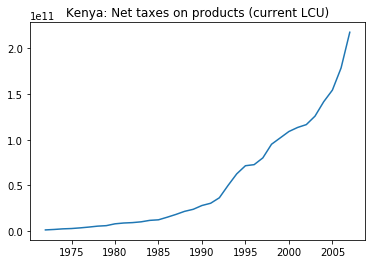

In [18]:
plt.plot(subtrain['value'])
plt.title("%s: %s"%(country, series))
plt.show()

## group and backfill

In [19]:
train.shape

(7034472, 5)

In [20]:
# test
df = pd.DataFrame([[np.nan, 2, np.nan, 0, 2, 2],
                   [3, 4, np.nan, 1, 1, 2],
                   [np.nan, np.nan, np.nan, 5, 1, 3],
                   [np.nan, 3, np.nan, 4, 1, 4],
                  ],
                  columns=list('ABCDEF'))
df['B'] = df.sort_values('F', ascending=True).groupby(['E'])['B'].fillna(method='ffill')
df

,A,B,C,D,E,F
0,NaN,2.0,NaN,0,2,2
1,3.0,4.0,NaN,1,1,2
2,NaN,4.0,NaN,5,1,3
3,NaN,3.0,NaN,4,1,4


In [21]:
train.shape

(7034472, 5)

In [22]:
n_nan_before = pd.isnull(train['value']).sum()
print('before: number of nan: %s'%n_nan_before)

before: number of nan: 3320285


In [23]:
# around 15 seconds
print(time.ctime(), 'start group')
train2 = train.copy()
train2 = train2.sort_values(['Country Name', 'Series Code', 'year'], ascending=True)
t_group = train2.groupby(['Country Name', 'Series Code'])
print(time.ctime(), 'end group')

Wed May 16 00:47:53 2018 start group
Wed May 16 00:47:58 2018 end group


In [24]:
# around 1 minute
print(time.ctime(), 'start fill')
train2['value'] = t_group['value'].fillna(method='ffill')
print(time.ctime(), 'end fill')

Wed May 16 00:47:58 2018 start fill
Wed May 16 00:48:45 2018 end fill


In [25]:
n_nan_after = pd.isnull(train2['value']).sum()
print('after: number of nan: %s'%n_nan_after)

after: number of nan: 2789631


## Fill remaining nan with bfill

In [34]:
# group again and backfill this time ... this is kind of cheating
# ~ 1 minute
print(time.ctime(), 'start fill')
t_group = train2.groupby(['Country Name', 'Series Code'])
train2['value'] = t_group['value'].fillna(method='bfill')
print(time.ctime(), 'end fill')
n_nan_after2 = pd.isnull(train2['value']).sum()
print('after: number of nan: %s'%n_nan_after2)

Wed May 16 01:00:51 2018 start fill
Wed May 16 01:01:36 2018 end fill
after: number of nan: 0


In [35]:
train2.reset_index().head()

,Unnamed: 0,year,Series Code,Country Name,Series Name,value
0,16,1972,2.1,Afghanistan,Achieve universal primary education,0.267007
1,16,1973,2.1,Afghanistan,Achieve universal primary education,0.267007
2,16,1974,2.1,Afghanistan,Achieve universal primary education,0.267007
3,16,1975,2.1,Afghanistan,Achieve universal primary education,0.267007
4,16,1976,2.1,Afghanistan,Achieve universal primary education,0.267007


## pivot table

- temporal dimension: year
- spatial dimension: country/series pair

This results in a transpose of the original dataframe

In [36]:
train3 = train2.reset_index().pivot(index='year', columns='Unnamed: 0', values='value')
train3.head()

Unnamed: 0,0,1,2,4,5,6,8,9,10,11,...,286107,286108,286109,286110,286112,286113,286114,286115,286116,286117
year,,,,,,,,,,,,,,,,,,,,,
1972,3.769214,7.027746,8.244887,12.933105,18.996814,22.423064,0.52056,14.963125,14.513759,0.0,...,25.18783,1.73152,4.806812,19.41161,31.7,12.0,27.8,31.2,22.3,54.5
1973,3.769214,7.027746,8.244887,12.933105,18.996814,22.423064,0.52056,14.963125,14.513759,0.0,...,25.18783,1.73152,4.806812,19.41161,31.7,12.0,27.8,31.2,22.3,54.5
1974,3.769214,7.027746,8.244887,12.933105,18.996814,22.423064,0.52056,14.963125,14.513759,0.0,...,25.18783,1.73152,4.806812,19.41161,31.7,12.0,27.8,31.2,22.3,54.5
1975,3.769214,7.027746,8.244887,12.933105,18.996814,22.423064,0.52056,14.963125,14.513759,0.0,...,25.18783,1.73152,4.806812,19.41161,31.7,12.0,27.8,31.2,22.3,54.5
1976,3.769214,7.027746,8.244887,12.933105,18.996814,22.423064,0.52056,14.963125,14.513759,0.0,...,25.18783,1.73152,4.806812,19.41161,31.7,12.0,27.8,31.2,22.3,54.5


In [53]:
train3[[16,559]].tail()

Unnamed: 0,16,559
year,,
2003,0.279609,0.325
2004,0.279609,0.360
2005,0.279609,0.395
2006,0.279609,0.430
2007,0.279609,0.465


In [33]:
train3.shape

(36, 195402)

## multi-variate OLS

0 / 737 .. 559
Coefficients: 
 [-2.88169357e-17 -6.65914948e-18  1.72463147e-18 ...  9.48227640e-32
 -1.93966024e-31  5.06180341e-31]
Mean squared error: 0.00
Variance score: 0.00


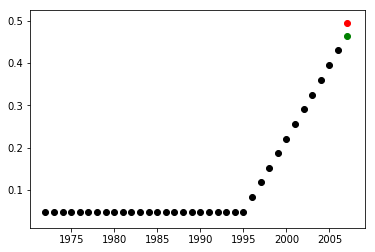

Coefficients: 
 [-3.39755548e-19 -7.85122679e-20  2.03336370e-20 ... -2.16218447e-32
  4.31927502e-32 -9.42366600e-33]
Mean squared error: 0.00
Variance score: 0.00


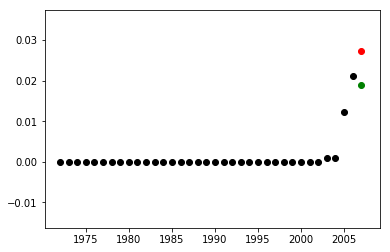

In [103]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
# from sklearn.decomposition import PCA

# reset so that years becomes a feature
diabetes_0 = train3.reset_index()

n = len(submit_inds)
for j, index in enumerate(submit_inds[:5]):
    if j%20==0: print("%s / %s .. %s"%(j, n, index))
    # target is a single country/series pair, features are all else
    diabetes_X = diabetes_0[list(set(diabetes_0.columns) - set([index]))].values
    diabetes_y = train3[index].values

    # to avoid multi-colinearity, reduce features

    # Method 1: select top n features
    # http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html#sphx-glr-auto-examples-plot-compare-reduction-py
    # This beats the performance of the PCA
    # mdl = SelectKBest(f_regression, k=40) # 20 and 40 are good
    # diabetes_X = mdl.fit_transform(diabetes_X, diabetes_y)

    # Method 2: PCA to reduce features
    # # mdl = PCA(n_components='mle') # TODO report bug
    # # mdl = PCA(n_components='mle', svd_solver = 'full') # mle not supported for n_samples < n_features
    # mdl = PCA(n_components=20, svd_solver = 'full') # 20 is too small resulting in too large error
    # diabetes_X = mdl.fit_transform(diabetes_X)

    # Split the data into training/testing sets
    n_test = 1
    diabetes_X_train = diabetes_X[:-1*n_test]
    diabetes_X_test = diabetes_X[-1*n_test:]

    # Split the targets into training/testing sets
    diabetes_y_train = diabetes_y[:-1*n_test]
    diabetes_y_test = diabetes_y[-1*n_test:]

    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(diabetes_X_train, diabetes_y_train)

    # Make predictions using the testing set
    diabetes_y_pred = regr.predict(diabetes_X_test)
    
    pred_r2 = r2_score(diabetes_y_test, diabetes_y_pred)

    if index in [559, 618]:
        # The coefficients
        print('Coefficients: \n', regr.coef_)
        # The mean squared error
        print("Mean squared error: %.2f"
              % mean_squared_error(diabetes_y_test, diabetes_y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % pred_r2)

        # Plot outputs
        # plt.scatter(train3.index, np.concatenate([diabetes_y_train, diabetes_y_test], axis=0),  color='black')
        plt.scatter(train3.index[:-1*n_test], diabetes_y_train, color='black')
        plt.scatter(train3.index[-1*n_test:], diabetes_y_test, color='green')
        plt.scatter(train3.index[-1*n_test:], diabetes_y_pred, color='red')

        #plt.xticks(())
        #plt.yticks(())

        plt.show()
        
    
    #if pred_r2 > 1 or pred_r2 < -1.1:
    #    raise ValueError("prediction r2 on %s = %.2f > 1 or < 0. Aborting"%(index, pred_r2))


In [101]:
x=[1,2,3,4,5]
x[:-1], x[-1:], x[:-0], x[-0:]

([1, 2, 3, 4], [5], [], [1, 2, 3, 4, 5])

In [ ]:
df_submit['slope'] = np.nan
df_submit['intercept'] = np.nan
df_submit['r_value'] = np.nan
df_submit['p_value'] = np.nan
df_submit['std_err'] = np.nan

In [ ]:
# least squares
# https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.stats.linregress.html
n = len(submit_inds)
for j, index in enumerate(submit_inds):
    if j%20==0: print("%s / %s .. %s"%(j, n, index))
    n_avail = len(np.where(train3.index == index)[0])
    if n_avail <= 1:
        print("skipping %s since only %s point available"%(index, n_avail))
        continue

    x = train3.loc[index, 'year'].values
    y = train3.loc[index, 'value'].fillna(value=0)
    y = y.values
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    df_submit.loc[index, 'slope'] = slope
    df_submit.loc[index, 'intercept'] = intercept
    df_submit.loc[index, 'r_value'] = r_value
    df_submit.loc[index, 'p_value'] = p_value
    df_submit.loc[index, 'std_err'] = std_err
    df_submit.loc[index, '2008 [YR2008]'] = slope*2008 + intercept
    df_submit.loc[index, '2012 [YR2012]'] = slope*2012 + intercept

## prepare submission file

In [ ]:
df_submit2 = df_submit.copy()
df_submit2 = df_submit2.fillna(value=0)
df_submit2 = df_submit2.reset_index()[['Unnamed: 0', '2008 [YR2008]', '2012 [YR2012]']]
df_submit2.rename(columns={'Unnamed: 0': ''}, inplace=True)
fn1, fn2 = make_submission(df_submit2)
fn1, fn2